In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas
import sympy as Ω
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import derivative
import pickle
from tqdm import tqdm_notebook as tqdm

from dataclasses import dataclass

import scipy.sparse
import scipy.sparse.linalg

import functools

In [4]:
Ω.init_printing()

In [5]:
i, k = Ω.symbols('i k')
I, K = Ω.symbols('I K')
h_x, h_t = Ω.symbols('h_x h_t')
l, T, H, D = Ω.symbols('l T H D')

In [6]:
u = Ω.IndexedBase('u', shape=(I + 1, K + 1))

In [7]:
gamma = Ω.symbols('gamma')
gamma_val = D * h_t / h_x**2

## простейшая явная

In [91]:
eqs = [
    (u[k, i] - u[k - 1, i]) / h_t - D * (u[k - 1, i + 1] - 2 * u[k - 1, i] + u[k - 1, i - 1]) / (h_x**2),
    (u[k, 1] - u[k, 0]) / h_x - H * u[k, 0],
    (u[k, I] - u[k, I - 1]) / h_x + H * u[k, I],
]
eqs[0] = (eqs[0] * h_t).expand().subs({gamma_val:gamma})
eqs

### $i=1,I-1$

In [92]:
Ω.solve(eqs[0], u[k, i])[0].expand().subs({gamma_val:gamma}).collect([
    u[k-1, i-1],
    u[k-1, i],
    u[k-1, i+1],
])

### $i=0$

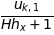

In [93]:
Ω.solve(eqs[1], u[k, 0])[0].expand().subs({gamma_val:gamma})

### $i=I$

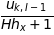

In [94]:
Ω.solve(eqs[2], u[k, I])[0].expand().subs({gamma_val:gamma})

## простейшая неявная

In [126]:
eqs = [
    (u[k, i] - u[k - 1, i]) / h_t - D * (u[k, i + 1] - 2 * u[k, i] + u[k, i - 1]) / (h_x**2),
    (u[k, 1] - u[k, 0]) / h_x - H * u[k, 0],
    (u[k, I] - u[k, I - 1]) / h_x + H * u[k, I],
]
eqs[0] = (eqs[0] * h_t).expand().subs({gamma_val:gamma})
eqs

### $i=1,I-1$

In [127]:
-eqs[0].collect([
    u[k, i-1],
    u[k, i],
    u[k, i+1],
])

### $i=0$

In [128]:
(-eqs[1] * h_x).expand().collect([
    u[k, 0],
    u[k, 1],
])

### $i=I$

In [129]:
(eqs[2] * h_x).expand().collect([
    u[k, I-1],
    u[k, I],
])

## КН

In [8]:
eqs = [
    (u[k, i] - u[k - 1, i]) / h_t - D / 2 * (
      (u[k-1, i + 1] - 2 * u[k-1, i] + u[k-1, i - 1]) +
      (u[k, i + 1] - 2 * u[k, i] + u[k, i - 1])
    ) / (h_x**2),
    (u[k, 1] - u[k, 0]) / h_x - H * u[k, 0],
    (u[k, I] - u[k, I - 1]) / h_x + H * u[k, I],
]
eqs[0] = (eqs[0] * 2 * h_t).expand().subs({gamma_val:gamma})
eqs

### $i=1,I-1$

In [123]:
(-eqs[0]).collect([
    u[k, i-1],
    u[k, i],
    u[k, i+1],
    u[k-1, i-1],
    u[k-1, i],
    u[k-1, i+1],
])

### $i=0$

In [124]:
(-eqs[1] * h_x).expand().collect([
    u[k, 0],
    u[k, 1],
])

### $i=I$

In [125]:
(eqs[2] * h_x).expand().collect([
    u[k, I-1],
    u[k, I],
])

## простейшая неявная повышенного порядка аппроксимации

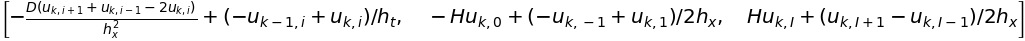

In [9]:
eqs = [
    (u[k, i] - u[k - 1, i]) / h_t - D * (u[k, i + 1] - 2 * u[k, i] + u[k, i - 1]) / (h_x**2),
    (u[k, 1] - u[k, -1]) / (2 * h_x) - H * u[k, 0],
    (u[k, I+1] - u[k, I - 1]) / (2 * h_x) + H * u[k, I],
]
# eqs[0] = (eqs[0] * h_t).expand().subs({gamma_val:gamma})
eqs

### $i=1,I-1$

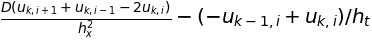

In [10]:
(-eqs[0]).collect([
    u[k, i-1],
    u[k, i],
    u[k, i+1],
    u[k-1, i-1],
    u[k-1, i],
    u[k-1, i+1],
])

### $i=0$

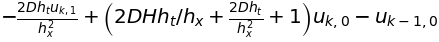

In [15]:
solution = Ω.solve(eqs[0].subs({i:0}), u[k, -1])[0]
# (-eqs[1]*2*h_x*gamma).subs({u[k, -1]: solution}).expand().collect([
#     u[k, 0],
#     u[k, 1],
# ])
(-eqs[1] * h_x * 2 * gamma_val).subs({u[k, -1]: solution}).expand().collect([
    u[k, 0],
    u[k, 1],
])

### $i=I$

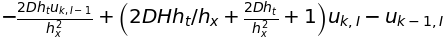

In [17]:
solution = Ω.solve(eqs[0].subs({i:I}), u[k, I+1])[0]
# (eqs[2] * 2 * h_x * gamma).subs({u[k, I+1]: solution}).expand().collect([
#     u[k, I-1],
#     u[k, I],
# ])
(eqs[2] * 2 * h_x * gamma_val).subs({u[k, I+1]: solution}).expand().collect([
    u[k, I-1],
    u[k, I],
])

## КН повышенного порядка аппроксимации

In [134]:
eqs = [
    (u[k, i] - u[k - 1, i]) / h_t - D / 2 * (
      (u[k-1, i + 1] - 2 * u[k-1, i] + u[k-1, i - 1]) +
      (u[k, i + 1] - 2 * u[k, i] + u[k, i - 1])
    ) / (h_x**2),
    (u[k, 1] - u[k, -1]) / (2 * h_x) - H * u[k, 0],
    (u[k, I+1] - u[k, I - 1]) / (2 * h_x) + H * u[k, I],
]
eqs[0] = (eqs[0] * 2 * h_t).expand().subs({gamma_val:gamma})
eqs

### $i=1,I-1$

In [135]:
(-eqs[0]).collect([
    u[k, i-1],
    u[k, i],
    u[k, i+1],
    u[k-1, i-1],
    u[k-1, i],
    u[k-1, i+1],
])

### $i=0$

In [150]:
(eqs[0]/2).subs({i:0}).subs({
    u[k, -1]: Ω.solve(eqs[1], u[k, -1])[0],
    u[k-1, -1]: Ω.solve(eqs[1], u[k, -1])[0].subs({k:k-1}),
}).expand().collect([
    u[k - 1, 0],
    u[k - 1, 1],
    u[k, 0],
    u[k, 1],
])

### $i=I$

In [151]:
(eqs[0]/2).subs({i:I}).subs({
    u[k, I+1]: Ω.solve(eqs[2], u[k, I+1])[0],
    u[k-1, I+1]: Ω.solve(eqs[2], u[k, I+1])[0].subs({k:k-1}),
}).expand().collect([
    u[k - 1, I],
    u[k - 1, I+1],
    u[k, I],
    u[k, I+1],
])